# Data

During the first phase, we prepare the data for further processing. First, the data (train, validation and test) are uncompressed and saved to catalogs.

In [1]:
from importlib import reload
import src.utils as utils
import os

In [2]:
data_dir_path = "data"
archive_name = "x_ray_detection.zip"

annotations_cat, images_cat = utils.load_data(data_dir_path, archive_name)

train data: 6181
valid data: 1766
test data: 883


In [14]:
reload(utils)

<module 'src.utils' from 'd:\\Programming\\XRayDetection_Py\\x_ray_detection\\src\\utils.py'>

To validate the correctness of the data, let us display a sample.

In [4]:
Xray = utils.DataStorage(annotations_cat, images_cat)

Path: data\train\042973_jpg.rf.6792837ba2183435721cd7b4e9674ecd.jpg


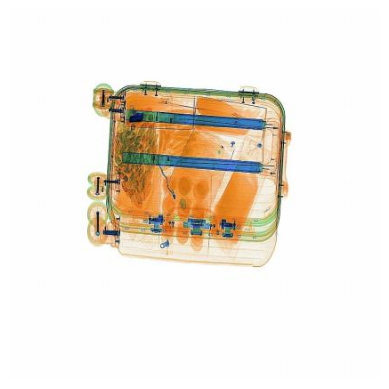

Box: [127, 108, 35.5, 36]


In [5]:
sample_img_path, sample_box = Xray.return_sample(42)

Path: data\train\042973_jpg.rf.6792837ba2183435721cd7b4e9674ecd.jpg
Box: [127, 108, 35.5, 36]


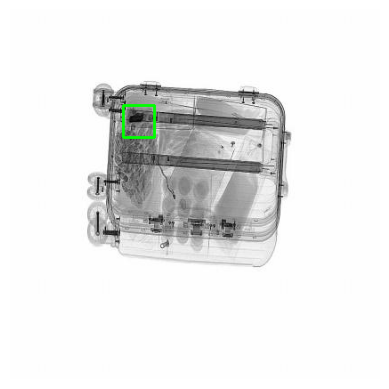

In [6]:
import cv2 as cv
import matplotlib.pyplot as plt

sample_img_path, sample_box = Xray.return_sample(42, plot=False)

sample_img = cv.imread(sample_img_path, cv.IMREAD_GRAYSCALE)
temp_color_img = cv.cvtColor(sample_img, cv.COLOR_GRAY2RGB)

utils.draw_rectangle(temp_color_img, sample_box, color=(0, 255, 0), thickness=2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

Creating dataset using custom COCO parser.

In [10]:
anns_file = '_annotations.coco.json'
imgs_dir = 'data/'

coco_train = utils.COCOParser(anns_file, f'{imgs_dir}/train/')
coco_valid = utils.COCOParser(anns_file, f'{imgs_dir}/valid/')
coco_test = utils.COCOParser(anns_file, f'{imgs_dir}/test/')

raw_train_ds = utils.create_dataset(coco_train, Xray.annot["train"]["images"], os.path.join(imgs_dir, "train"), 0.1)
raw_valid_ds = utils.create_dataset(coco_valid, Xray.annot["valid"]["images"], os.path.join(imgs_dir, "valid"), 0.1)
raw_test_ds = utils.create_dataset(coco_test, Xray.annot["test"]["images"], os.path.join(imgs_dir, "test"), 0.1)

In [13]:
train_ds = utils.tune_training_ds(raw_train_ds)
valid_ds = utils.tune_validation_ds(raw_valid_ds)

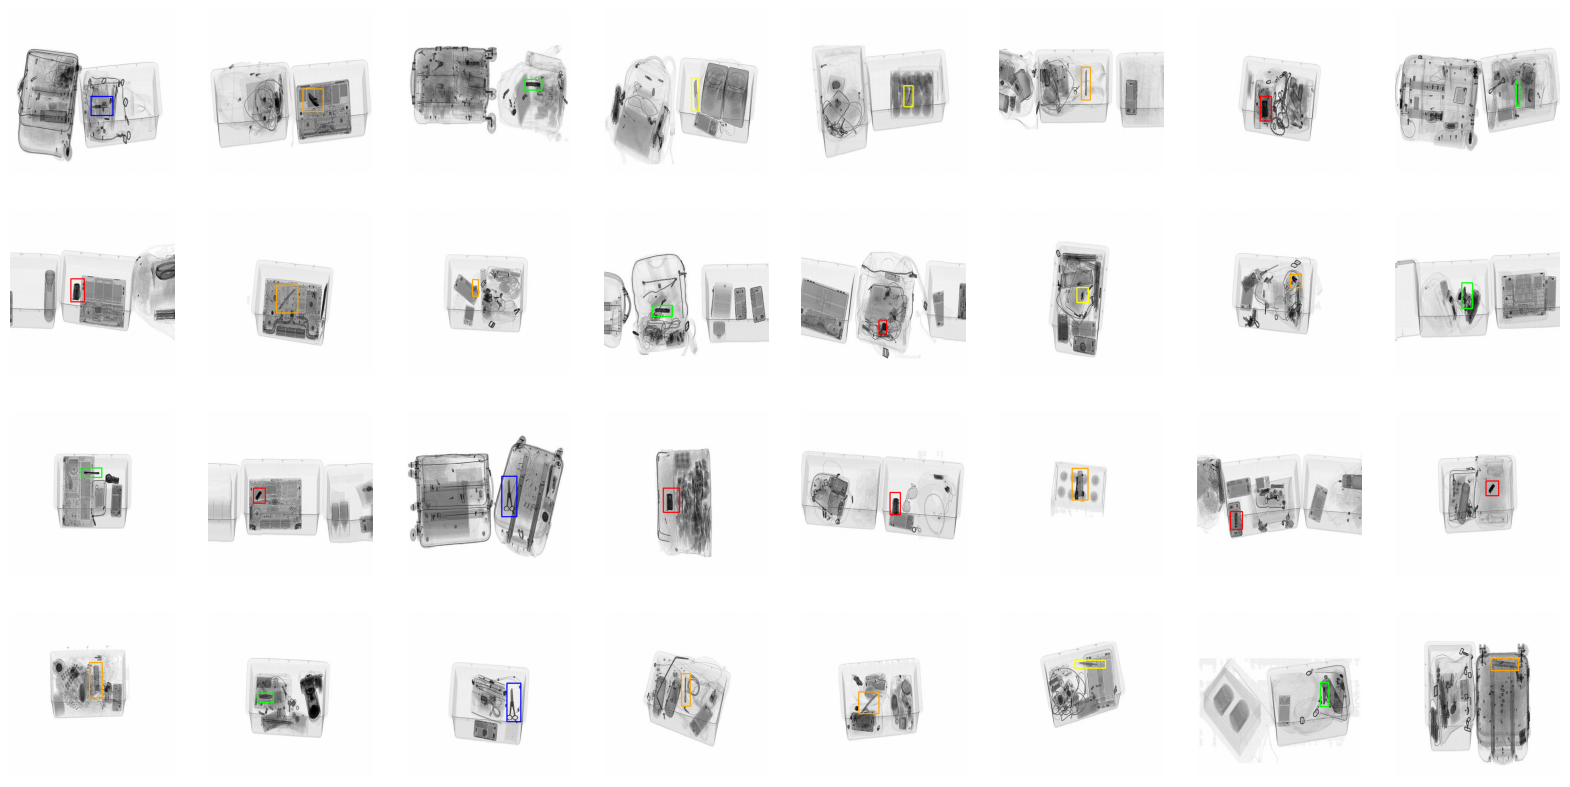

In [15]:
utils.plot_batch(train_ds)

# Model

In [17]:
import src.model as model

detector = model.get_model()

detector.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 414, 414, 16)         160       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 207, 207, 16)         0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 205, 205, 32)         4640      ['average_pooling2d[0][0]

In [25]:
EPOCHS = 5

history = detector.fit(train_ds,
                    steps_per_epoch=(len(raw_train_ds) // BATCH_SIZE),
                    validation_data=valid_ds, validation_steps=1, 
                    epochs=EPOCHS,
                    verbose=0)

KeyboardInterrupt: 